# Libraries, paths, functions, and constants

In [1]:
!nvidia-smi

Sat Apr  5 10:54:11 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.77                 Driver Version: 565.77         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L40                     Off |   00000000:28:00.0 Off |                    0 |
| N/A   36C    P8             35W /  300W |       1MiB /  46068MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os

import sys
sys.path.append(f"../../3_train_and_test_models")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from params import ROOT, SPECIES, TFS

# Calculate and visualize cosine similarity

Processing CEBPA via the cosine similarity...


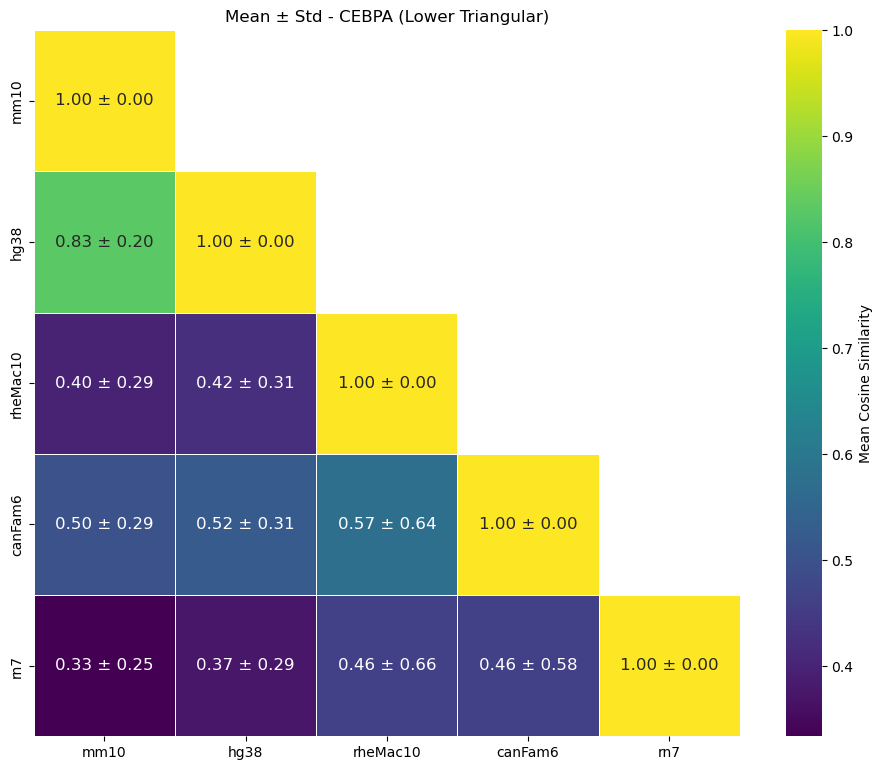

Processing FOXA1 via the cosine similarity...


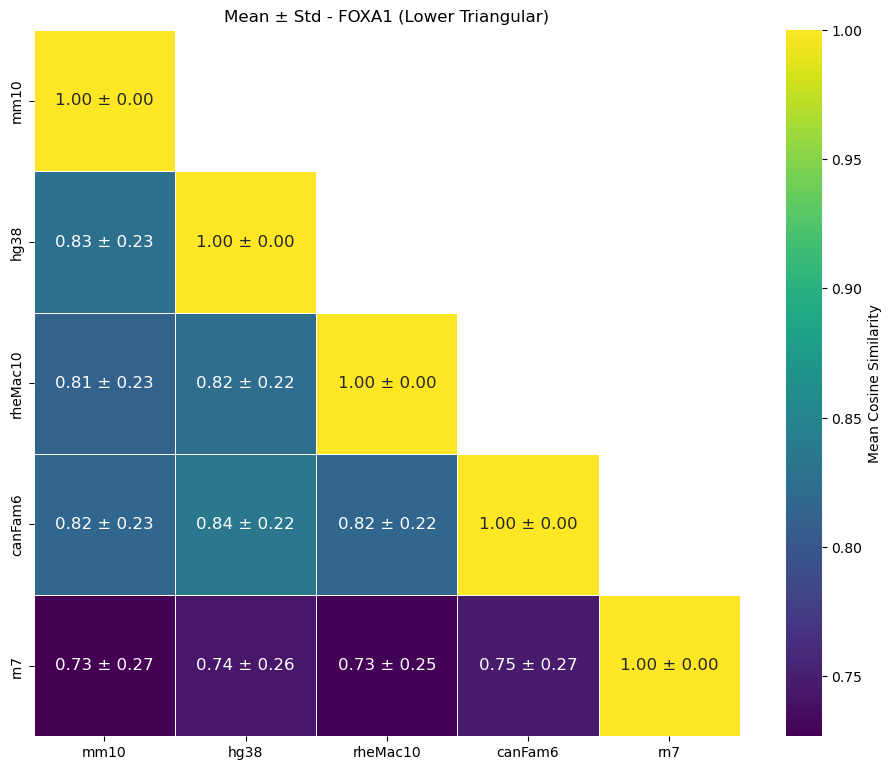

Processing HNF4A via the cosine similarity...


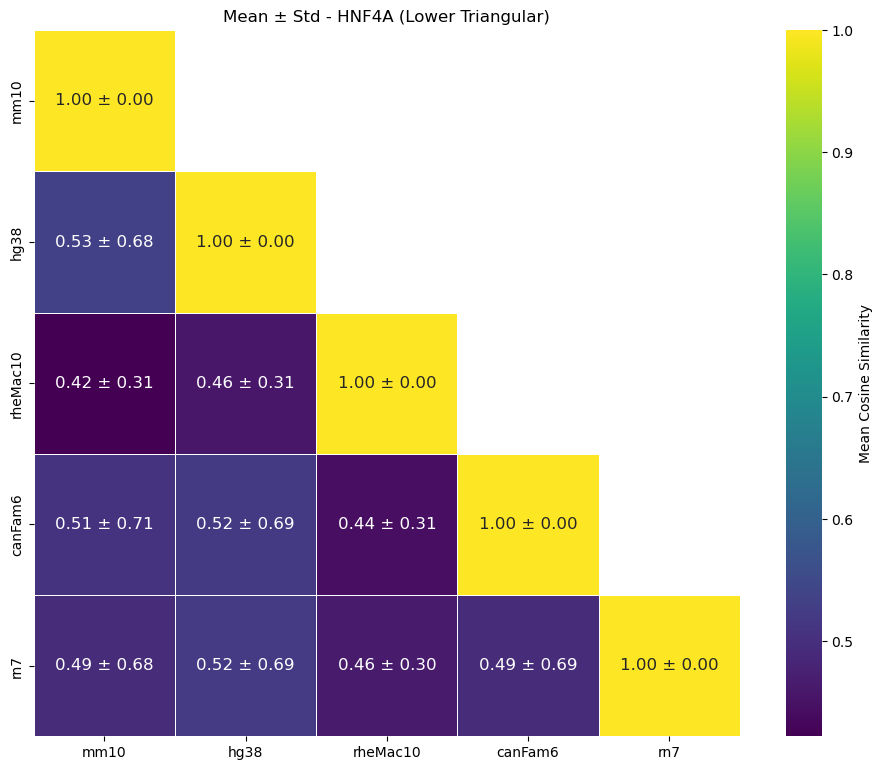

Processing HNF6 via the cosine similarity...


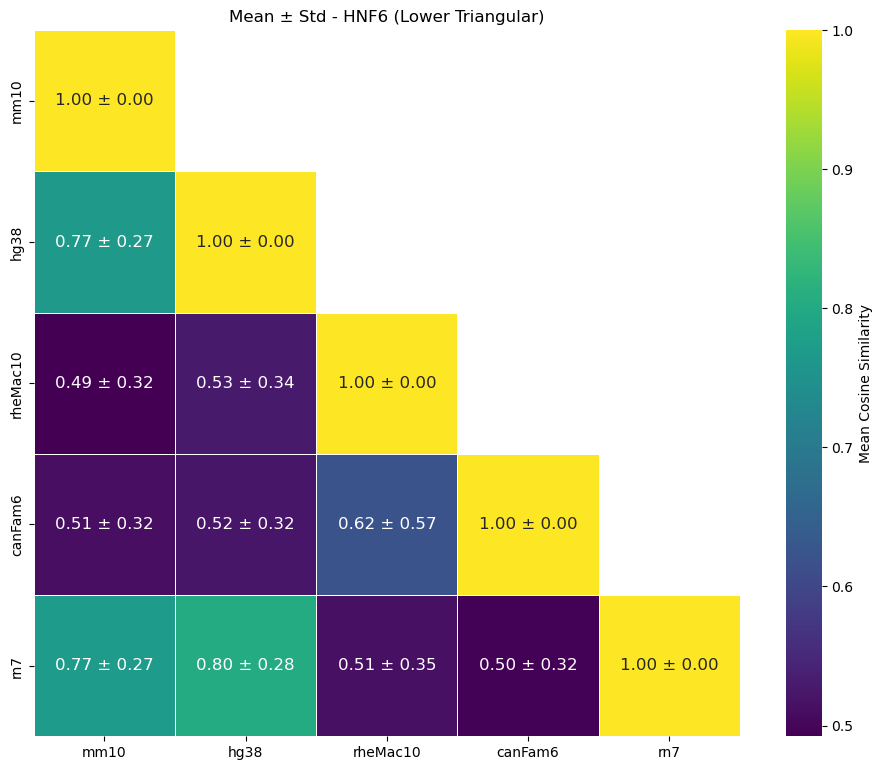

In [3]:
cos = nn.CosineSimilarity(dim=1, eps=1e-08)

for tf in TFS:
    summary_stats = []
    print(f"Processing {tf} via the cosine similarity...")
    for i in SPECIES:
        for j in SPECIES:

            # We only need to calculate only lower triangle pairs!
            # (This sh*t is symmetric)
            if SPECIES.index(j) > SPECIES.index(i):
                 continue
            
            try:
                embedding_i = torch.from_numpy(np.load(f"{ROOT}/embeddings/MORALE_{tf}_{i}-tested.embedding.npy", allow_pickle=True))
                embedding_j = torch.from_numpy(np.load(f"{ROOT}/embeddings/MORALE_{tf}_{j}-tested.embedding.npy", allow_pickle=True))

                if embedding_i.shape != embedding_j.shape or embedding_i.ndim != 2:
                    print(f"  Skipping {i} vs {j} due to shape mismatch or non-2D array.")
                    continue

                if embedding_i.shape[0] == 0:
                    print(f"  Skipping {i} vs {j} due to empty embedding.")
                    continue

                cs = cos(embedding_i, embedding_j).cpu().numpy()

                mean_val = np.mean(cs)
                median_val = np.median(cs)
                std_val = np.std(cs)

                summary_stats.append({
                    "species_i": i,
                    "species_j": j,
                    "mean_sim": mean_val,
                    "median_sim": median_val,
                    "std_sim": std_val
                })

            except FileNotFoundError:
                 print(f"  Skipping {i} vs {j}: One or both embedding files not found.")
            except Exception as e:
                print(f"  Skipping {i} vs {j} due to error: {e}")

    summary_df = pd.DataFrame(summary_stats)

    # --- Create Heatmap(s) ---

    # Pivot for heatmap format
    mean_sim_matrix = summary_df.pivot(index='species_i', columns='species_j', values='mean_sim')
    std_sim_matrix = summary_df.pivot(index='species_i', columns='species_j', values='std_sim')

    # Ensure correct species order and fill potential missing pairs (NaN)
    mean_sim_matrix = mean_sim_matrix.reindex(index=SPECIES, columns=SPECIES)
    std_sim_matrix = std_sim_matrix.reindex(index=SPECIES, columns=SPECIES)

    # --- Create Custom Annotation Labels (Mean ± Std) ---

    # Initialize an empty DataFrame for labels, ensures alignment
    annot_labels = pd.DataFrame('', index=mean_sim_matrix.index, columns=mean_sim_matrix.columns)
    for r in mean_sim_matrix.index:
        for c in mean_sim_matrix.columns:

            mean_val = mean_sim_matrix.loc[r, c]
            std_val = std_sim_matrix.loc[r, c]

            # Check if values are NaN before formatting
            if pd.notna(mean_val) and pd.notna(std_val):
                annot_labels.loc[r, c] = f"{mean_val:.2f} ± {std_val:.2f}"
            else:
                annot_labels.loc[r, c] = "N/A"

    # --- Create Mask for Upper Triangle ---
    
    mask = np.triu(np.ones_like(mean_sim_matrix, dtype=bool), k=1)

    # --- Plot and save the figure ---

    plt.figure(figsize=(10, 8))

    sns.heatmap(
        mean_sim_matrix,
        mask=mask,
        annot=annot_labels,
        fmt="",
        cmap="viridis",
        linewidths=.5,
        cbar_kws={'label': 'Mean Cosine Similarity'},
        square=True,
        annot_kws={"size": 12}
    )

    plt.title(f"Mean ± Std - {tf} (Lower Triangular)")
    plt.tight_layout()
    plt.ylabel(None)
    plt.xlabel(None)

    plt.savefig(
        f"{ROOT}/plots/Figure7/cosine-similarity_{tf}.pdf",
        format='pdf',
        dpi=600, # rasterized elements if any
        bbox_inches='tight'
    )

    plt.show()
    plt.close()

# Calculate and visualize wasserstein distance

Processing CEBPA via the Wasserstein Distance...


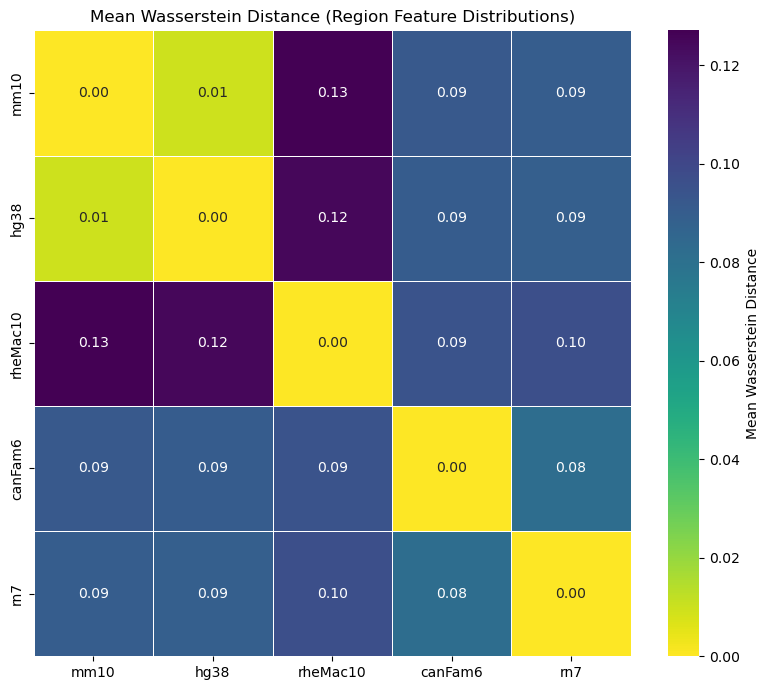

Processing FOXA1 via the Wasserstein Distance...


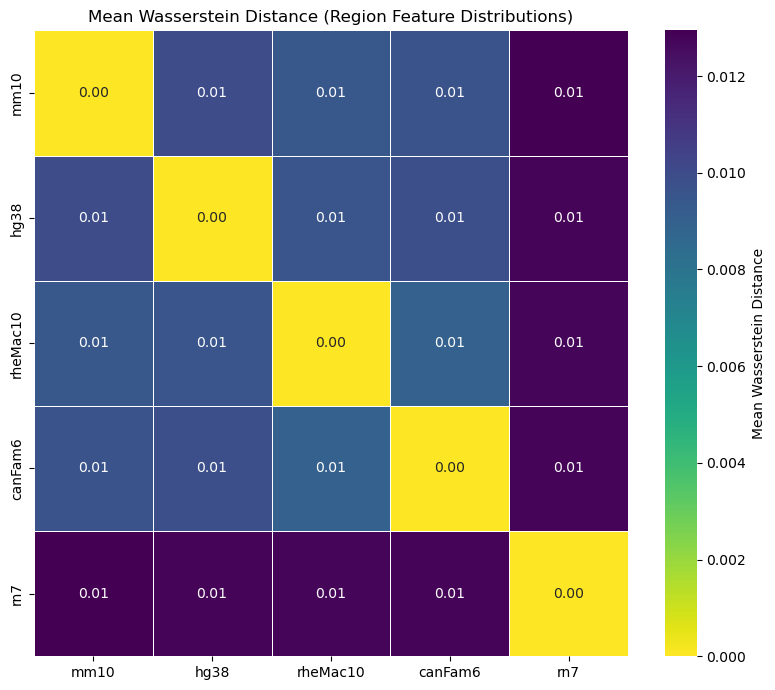

Processing HNF4A via the Wasserstein Distance...


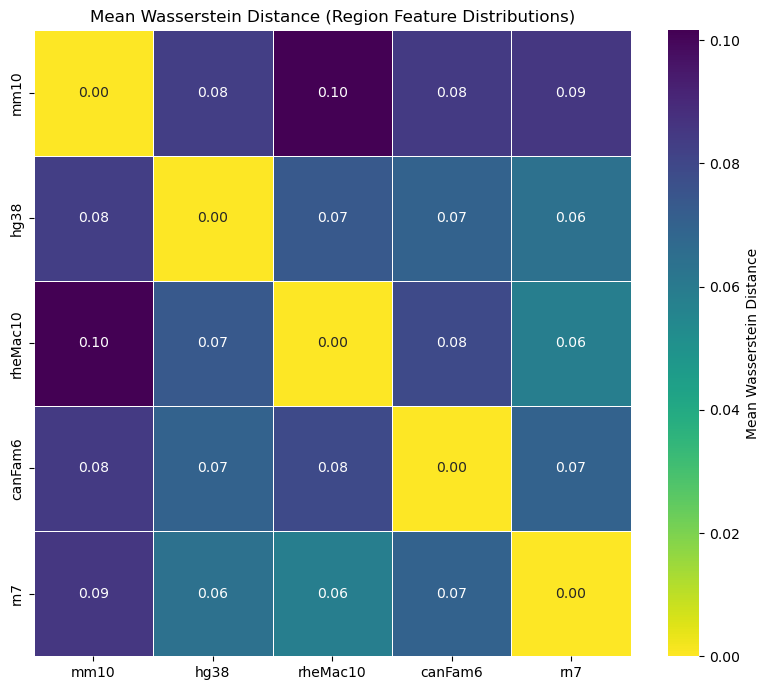

Processing HNF6 via the Wasserstein Distance...


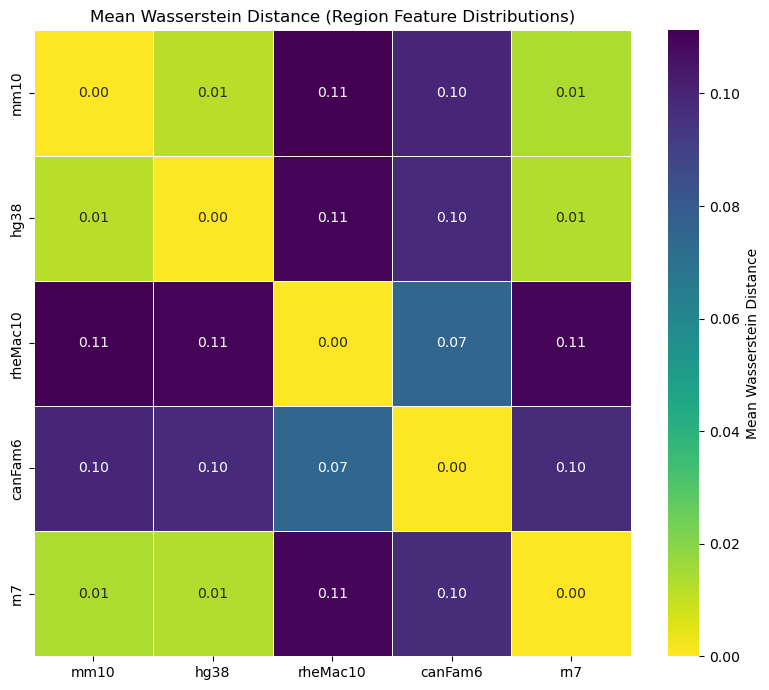

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.stats import wasserstein_distance

for tf in TFS:
    all_distances = []
    print(f"Processing {tf} via the Wasserstein Distance...")
    for i in SPECIES:
        for j in SPECIES:
            if i == j:
                continue # Wasserstein distance to self is 0, handle later for heatmap if needed
            try:
                # Load as numpy arrays directly
                embedding_i_np = np.load(f"{ROOT}/embeddings/MORALE_{tf}_{i}-tested.embedding.npy", allow_pickle=True)
                embedding_j_np = np.load(f"{ROOT}/embeddings/MORALE_{tf}_{j}-tested.embedding.npy", allow_pickle=True)

                # --- Validation ---
                if embedding_i_np.shape != embedding_j_np.shape or embedding_i_np.ndim != 2:
                    print(f"  Skipping {i} vs {j} due to shape mismatch or non-2D array.")
                    continue
                if embedding_i_np.shape[0] == 0:
                    print(f"  Skipping {i} vs {j} due to empty embeddings.")
                    continue

                # Ensure float type for wasserstein distance calculation
                embedding_i_np = embedding_i_np.astype(np.float64)
                embedding_j_np = embedding_j_np.astype(np.float64)

                # --- Calculate region-wise Wasserstein distances ---
                num_regions = embedding_i_np.shape[0]
                region_distances = np.zeros(num_regions)
                for k in range(num_regions):
                    # Treat features within each region's embedding as 1D distributions
                    vec_i = embedding_i_np[k, :]
                    vec_j = embedding_j_np[k, :]
                    # Handle case where vectors might be constant (no distribution)
                    if np.all(vec_i == vec_i[0]) and np.all(vec_j == vec_j[0]):
                        region_distances[k] = np.abs(vec_i[0] - vec_j[0]) # Simple distance if both are constant
                    elif np.all(vec_i == vec_i[0]): # Handle one constant vector
                        region_distances[k] = wasserstein_distance([vec_i[0]], vec_j) # WD between delta func and dist
                    elif np.all(vec_j == vec_j[0]):
                        region_distances[k] = wasserstein_distance(vec_i, [vec_j[0]])
                    else:
                        region_distances[k] = wasserstein_distance(vec_i, vec_j)

                # --- Store results for plotting ---
                pair_label = f"{i}_vs_{j}"
                for dist_value in region_distances:
                    all_distances.append({
                        "pair": pair_label,
                        "species_i": i,
                        "species_j": j,
                        "wasserstein_distance": dist_value
                    })

            except Exception as e:
                print(f"  Skipping {i} vs {j} due to error: {e}")

    # --- Create DataFrame ---
    dist_df = pd.DataFrame(all_distances)

    # --- Heatmap (Shows summary stat of region-wise distances) ---
    heatmap_stats = []
    for i in SPECIES:
        for j in SPECIES:
            if i == j:
                heatmap_stats.append({"species_i": i, "species_j": j, "mean_dist": 0.0, "median_dist": 0.0})
                continue

            # Get distances for this pair from the collected data
            pair_distances = dist_df[(dist_df['species_i'] == i) & (dist_df['species_j'] == j)]['wasserstein_distance']

            if len(pair_distances) > 0:
                heatmap_stats.append({
                    "species_i": i,
                    "species_j": j,
                    "mean_dist": pair_distances.mean(),
                    "median_dist": pair_distances.median()
                })

    heatmap_df = pd.DataFrame(heatmap_stats)

    # Pivot (choose mean or median)
    mean_dist_matrix = heatmap_df.pivot(index='species_i', columns='species_j', values='mean_dist')
    mean_dist_matrix = mean_dist_matrix.reindex(index=SPECIES, columns=SPECIES) # Ensure order

    plt.figure(figsize=(8, 7))
    sns.heatmap(
        mean_dist_matrix,
        annot=True,
        fmt=".2f",
        cmap="viridis_r", # Use a reversed map (_r) so low distance=similar=darker/yellow
        linewidths=.5,
        cbar_kws={'label': 'Mean Wasserstein Distance (Region Feature Distributions)'}
    )

    plt.ylabel(None)
    plt.xlabel(None)
    plt.tight_layout()
    # plt.savefig(f"{ROOT}/plots/wasserstein_summary_heatmap_mean.png", dpi=300)
    plt.show()

----